#**Loans Case Study**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns

In [3]:
loans = pd.read_csv(r"/content/drive/MyDrive/loans_full_schema.csv")

In [7]:
 missing = loans.isnull().sum()
 missing = missing.to_frame()
 missing = missing[missing[0]>0]
 missing

,0
emp_title,833
emp_length,817
verification_income_joint,8505
months_since_last_delinq,5658
months_since_90d_late,7715
months_since_last_credit_inquiry,1271
num_accounts_120d_past_due,318


**Handling Missing Data <br>**
The default way is to remove rows with missing data, but since I am building a model from the data, I want to keep as much data as possible.

One reason there is missing data is becuase some applications are not joint applications and therefore, columns regarding joint application information are left empty. Instead of having annual_income versus annual_income_joint and debt_to_interest versus debt_to_interest_joint, I combined these columns to create annual_income_total and debt_to_interest_total. I also created joint_application column to identify whether the account is joint or not. 

I also made a column that held the number of missing values for each application. Perhaps the person has something to hide, and is a more risker applicant.<br>

**Assumptions** <br>
Some rows that were missing data such as 'months_since_last_delinq',
'months_since_90d_late','months_since_last_credit_inquiry',
and 'num_accounts_120d_past_due', I assumed that the value was 0.

Some rows where missing emp_length information. I filled the rows with the mean emp_length. This method is okay as the mean reflects the majority of the data.

I assumed applicants that are 'Not Verified' if they have annual_income_joint but 'NA' in verification_income_joint.



In [8]:
def fill_missing(df, fill):
  df = df.fillna(fill)
  return df

In [256]:
loans.loc[(loans.verification_income_joint.isnull()) & (loans.annual_income_joint.notnull()),'verification_income_joint'] = 'Not Verified'
loans['joint_application'] = 'no'

loans.loc[loans.annual_income_joint.notnull(),'joint_application'] = 'yes'
loans['annual_income_total'] = loans['annual_income']
loans.loc[loans.joint_application == 'yes','annual_income_total'] = loans['annual_income_joint']
loans['debt_to_income_total'] = loans['debt_to_income_joint']
loans.loc[loans.joint_application == 'no', 'debt_to_income_total'] = loans['debt_to_income']
loans['joint_only_income'] = abs(loans['annual_income_total'] - loans['annual_income'])
loans_1 = loans.drop(columns=['annual_income','debt_to_income_joint','debt_to_income','annual_income_joint'])

In [257]:
cols = ['months_since_last_delinq',
         'months_since_90d_late',
         'months_since_last_credit_inquiry',
         'num_accounts_120d_past_due']
loans_1[cols] = fill_missing(loans_1[cols],0)

In [258]:
loans_1['missing_values']= loans_1.isnull().sum(axis=1).tolist()
loans_1['verification_income_joint'] = fill_missing(loans_1['verification_income_joint'],'NA')
loans_1['emp_length'] = fill_missing(loans_1['emp_length'],int(loans_1.emp_length.mean()))
loans_1['emp_title']=fill_missing(loans_1['emp_title'],'Other')

**Visualization #1: Histograms** <br>
Histograms of each column were generated. It is useful to notice if column has data that is normally distributed, has outliers, is categorical, binomial, large/small values, or skewed. This information is helpful when building models so the column can be normalized or scaled later on. <br>
Also, exploratory data analysis can be done by observing histograms. Here are several interesting histograms. The emp_length histogram is not continous. The debt_to_income_total histogram is normally distributed. The num_open_cc_accounts histogram shows that it is rare for applicants to have more than 20 active credit card accounts, and majority applicants have less than 10 active accounts. The months_since_last_delinq histogram drops of at 80 months since last delinqency.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


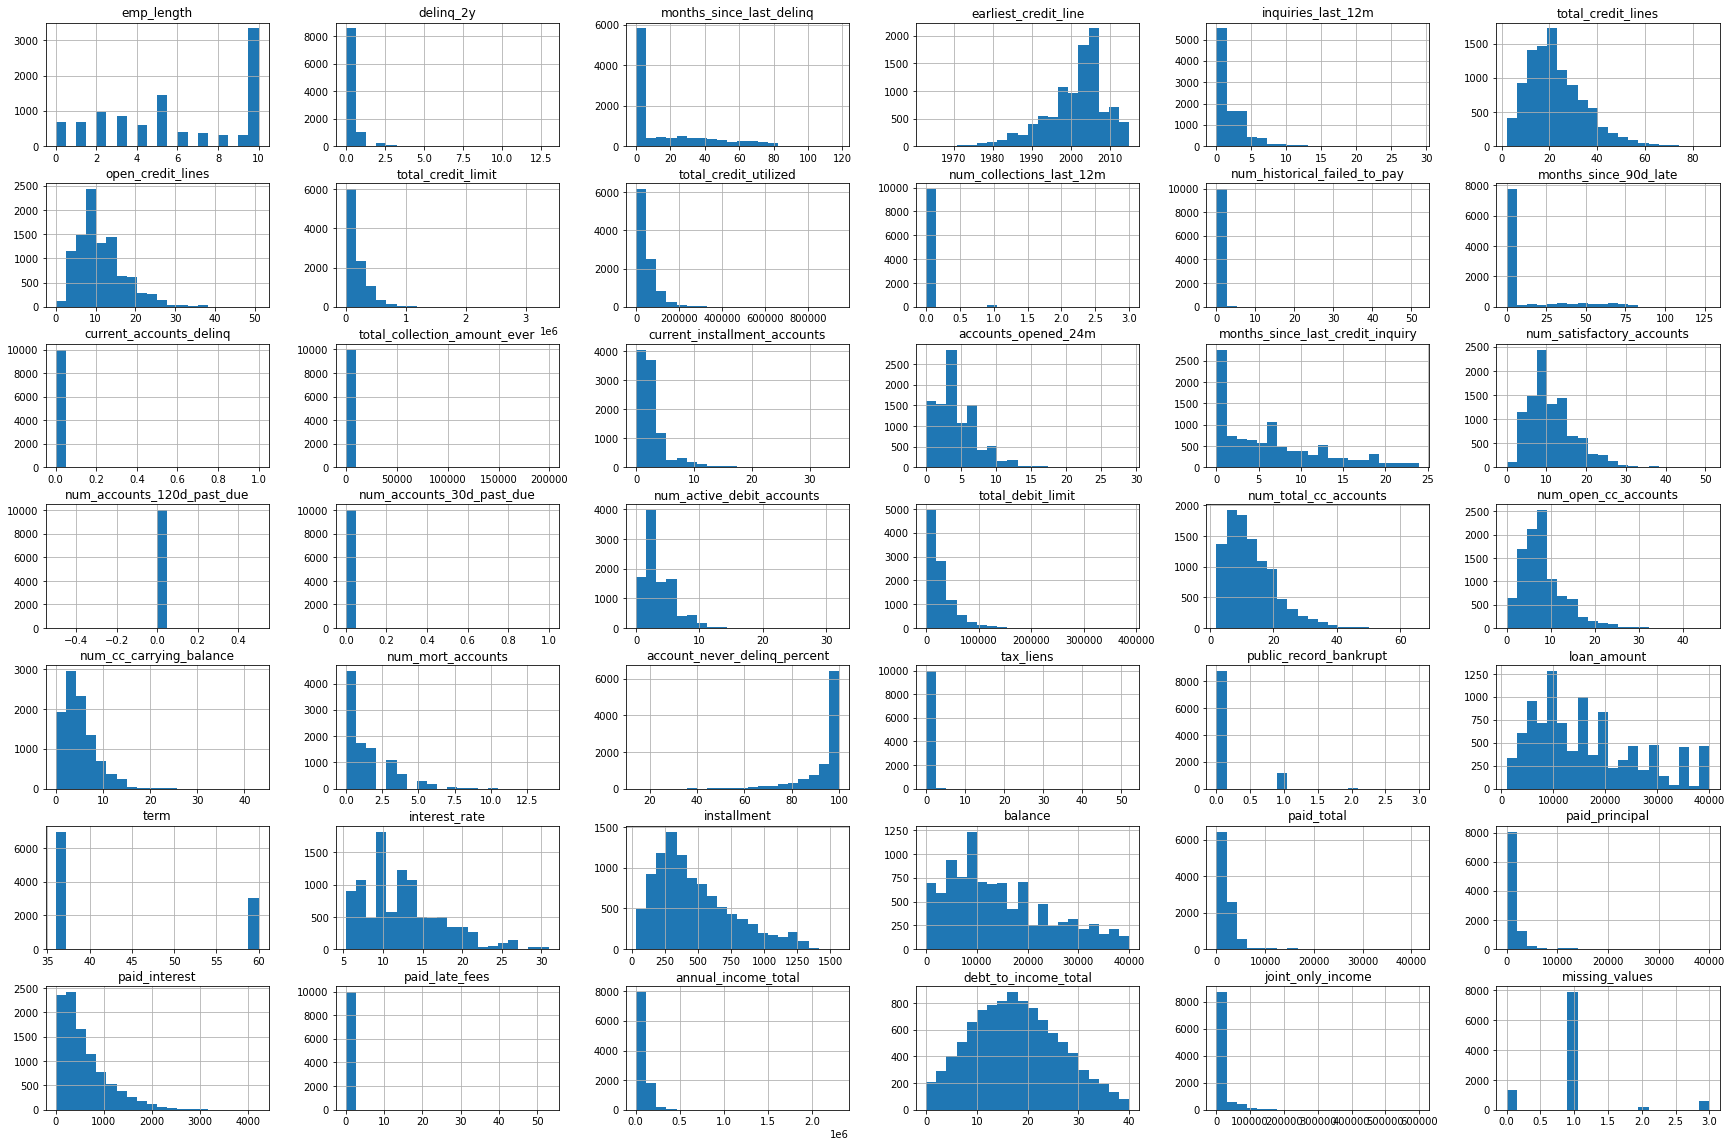

In [259]:
fig = plt.figure(figsize = (30,20))
ax = fig.gca()
loans_1.hist(ax=ax, bins=20)
fig.show()

**Scaling & Transforming Data** <br>
Since I will be using regression models, there is no need for standardizing the data. Categorical data will be encoded with labels. 

In [16]:
loans_1[['emp_length', 'months_since_last_delinq', 'months_since_90d_late',
       'months_since_last_credit_inquiry', 'num_accounts_120d_past_due']]=loans_1[['emp_length', 'months_since_last_delinq', 'months_since_90d_late',
       'months_since_last_credit_inquiry', 'num_accounts_120d_past_due']].astype(int)

In [262]:
categoricals = loans_1.select_dtypes(include='object').astype('category')
ints = loans_1.select_dtypes(include='int64').astype(int)
floats = loans_1.select_dtypes(include='float64')

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoded = categoricals.apply(LabelEncoder().fit_transform)
encoded.head()

In [ ]:
loans_2 = pd.concat([encoded,ints],axis=1)
loans_2 = pd.concat([loans_2,floats],axis=1)

**Model #1: Ordinary Least Squares (OLS) Linear Regression Model** <br> First model is Linear Regression Model using ordinary least squares method. I'll use this model to find significant features to use in the second model.

In [267]:
X = loans_2.drop(columns=['interest_rate'])
y = loans_1.interest_rate

In [268]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=0)

In [ ]:
import statsmodels.api as sm
X = sm.add_constant(X)
results = sm.OLS(y_train,X_train).fit()

In [270]:
from sklearn.metrics import r2_score
predictions = results.predict(X_test)
print("Regression score: ", r2_score(predictions,y_test))

Regression score:  0.9888228014179725


**Visualization #2: Predicted versus Actual** <br>
This plot shows the discrepanices between the predicted value versus the actual value. Predicted values that are close to the actual value should lie close to or on the diagonal line. Overall, majority of the predictions were close to the actual values, as most points lie near the line.

Text(0, 0.5, 'Predicted')

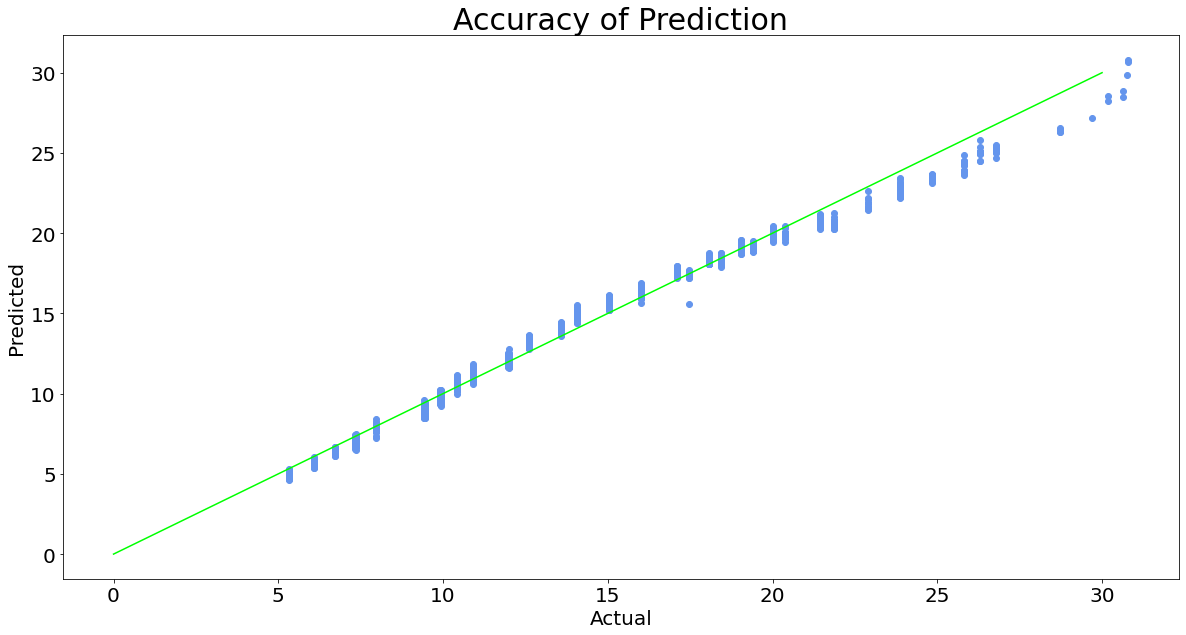

In [286]:
plt.figure(figsize=(20, 10))
plt.scatter(y_test,predictions,color = 'cornflowerblue')
plt.plot([0,30],[0,30], color='lime')
plt.title('Accuracy of Prediction',size=30)
plt.xlabel('Actual',size=20)
plt.yticks(size=20)
plt.xticks(size=20)
plt.ylabel('Predicted',size=20)plt.show()

In [194]:
results_summary = results.summary()
results_metric = results_summary.tables[0].as_html()
results_metric = pd.read_html(results_metric, header=0)[0]

results_coeff = results_summary.tables[1].as_html()
results_coeff = pd.read_html(results_coeff,header=0)[0]
results_coeff.columns = ['features', 'coef', 'std err', 't', 'P>|t|', '[0.025', '0.975]']

**Visualization #3: Most Significant Features** <br>
This graph shows the seven most significant features. These seven features have a p-value of less than 0.001, which means that these features are statistically significant and high probability to be important features for this model. The coefficients for each of these features is also displayed, to determine the size of influence the feature has. The constant, grade, and subgrade have the largest coefficients out of the seven. These features (excluding the constant) will become a feature set to be used on the next model.

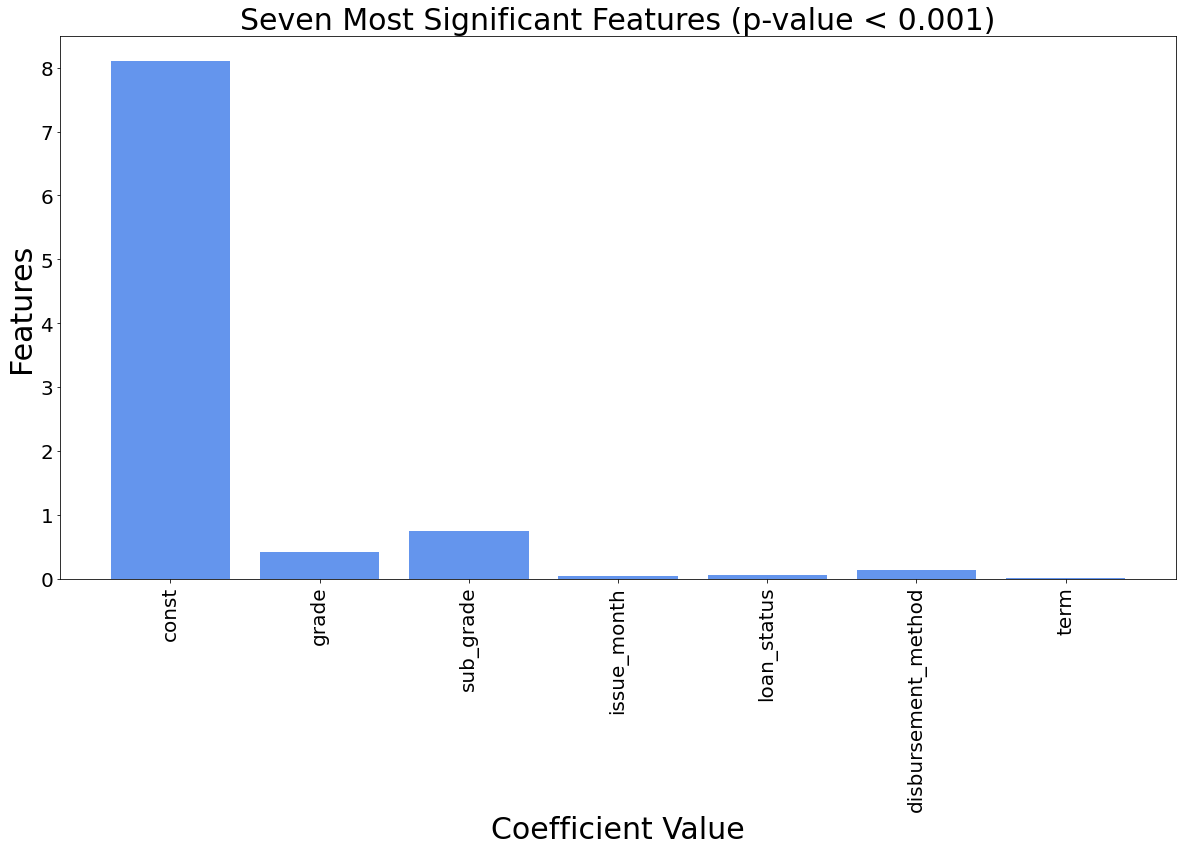

In [251]:
df_001 = results_coeff[(results_coeff['P>|t|'] < 0.001) & (results_coeff['coef'] > 0.01)]
plt.figure(figsize=(20, 10))
plt.bar(df_001['features'], df_001['coef'], color = 'cornflowerblue')
plt.title('Seven Most Significant Features (p-value < 0.001)', size=30)
plt.ylabel('Coefficient Value', size=30)
plt.xlabel('Features', size=30)
plt.xticks(rotation='vertical',size=20)
plt.yticks(size=20)
plt.show()

**Model #2: GradientBoostingRegressor** <br>
This model is also an regression model, but with an ensemble element. It is optimized with gradient descent and regression tree.

In [290]:
X = loans_2[['grade','sub_grade','issue_month','loan_status','disbursement_method','term']]
y = loans_1.interest_rate

In [291]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=0)

In [292]:
from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor(random_state=0).fit(X_train, y_train)
predictions = reg.predict(X_test)
print("Regression score: ", reg.score(X_test, y_test))

Regression score:  0.999910113823034


**Visualization #4** <br>
Here is another visualization of predicted and actual values, but from the gradientboostingregressor model. Compared to OLS accuracy of prediction graph from above, the points on this graph lie closer along the line. This result means that this model performance is better than the OLS model, and that this feature set is also well suited for the model.


Text(0, 0.5, 'Predicted')

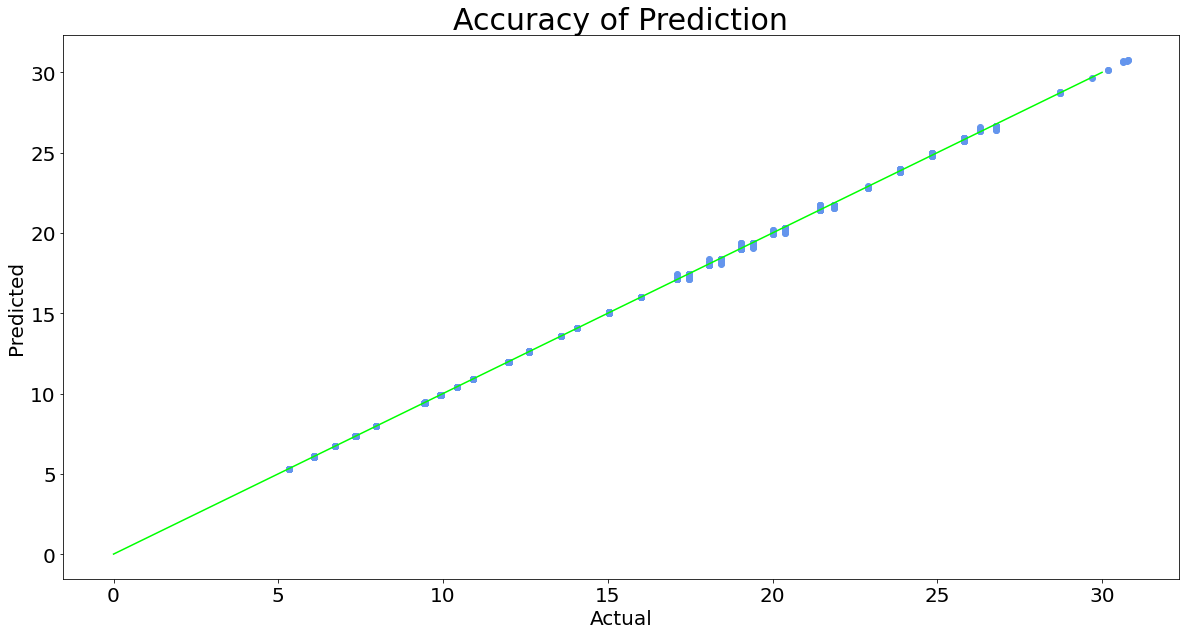

In [294]:
plt.figure(figsize=(20, 10))
plt.scatter(y_test,predictions,color = 'cornflowerblue')
plt.plot([0,30],[0,30], color='lime')
plt.title('Accuracy of Prediction',size=30)
plt.xlabel('Actual',size=20)
plt.yticks(size=20)
plt.xticks(size=20)
plt.ylabel('Predicted',size=20)

**Visualization #5**<br>
This visualization show what the GradientBoostingRegressor model deems as important features in the feature set. Here, grade and sub_grade attributes are two most important features, while the other features have negligent impact when predicting the interest rate. 

This makes sense becuase grade and sub_grade identifies what kind of loan the applicant is applying for, and the there is a certain general interest that is offered with this type of grade and sub_grade of loan.

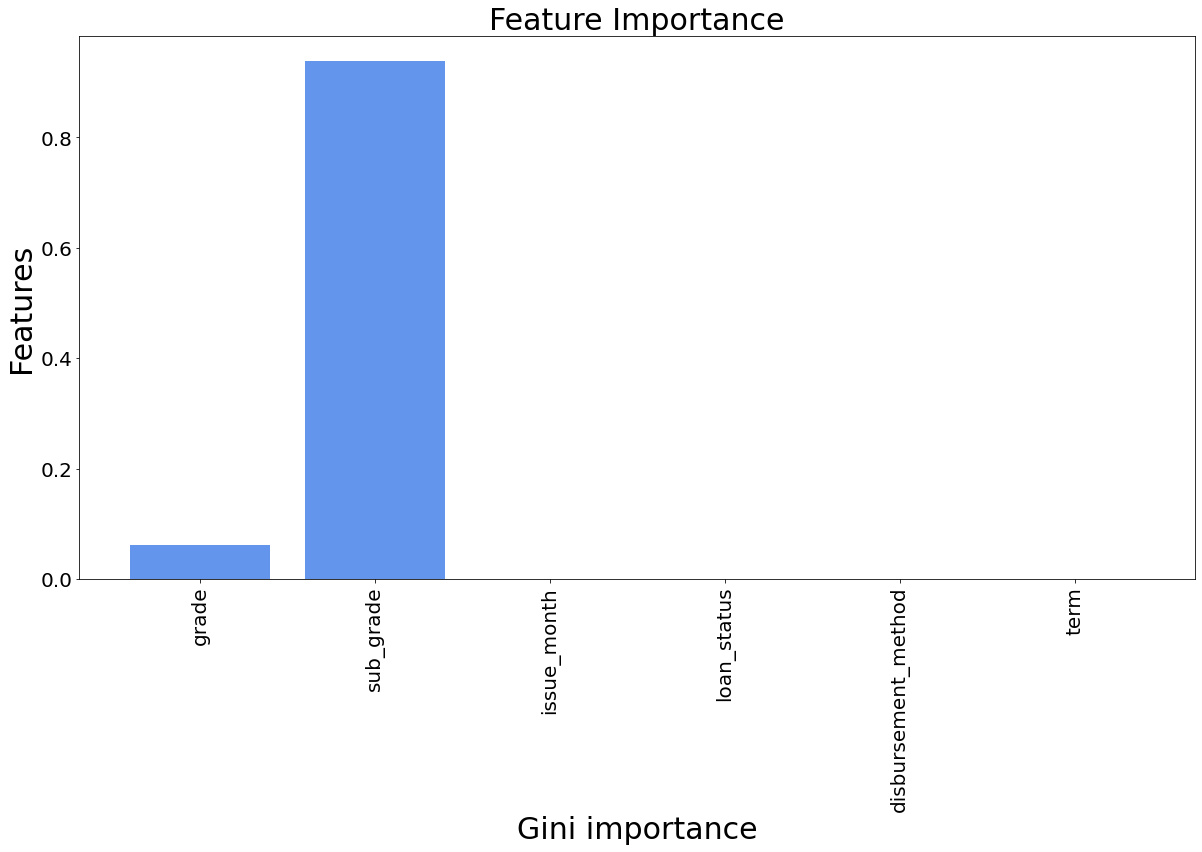

In [295]:
plt.figure(figsize=(20, 10))
plt.bar(X.columns, reg.feature_importances_, color = 'cornflowerblue')
plt.title('Feature Importance', size=30)
plt.xlabel('Gini importance', size=30)
plt.ylabel('Features', size=30)
plt.xticks(rotation='vertical',size=20)
plt.yticks(size=20)
plt.show()

**Visualization #6** <br>
This visualization takes a closer look at the grade and sub_grade attributes and thier relationship with interest rate. 

In the grade versus interest rate graph, each grade seems to have an range of interest rate that is offered, very rarely the interest rate deviates from these ranges. This means that the grade attribute doesn't have a completely linear relationship with interest rate, and is bounded by some sort of rule. This is also why gradientboostingregession model worked better to model this pattern rather than the simple OLS model.

In the sub_grade versus interest rate graph, a positive linear relationship is noticable, as the points are close to the line and follow the line.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0.5, 1.0, 'sub_grade versus interest rate')]

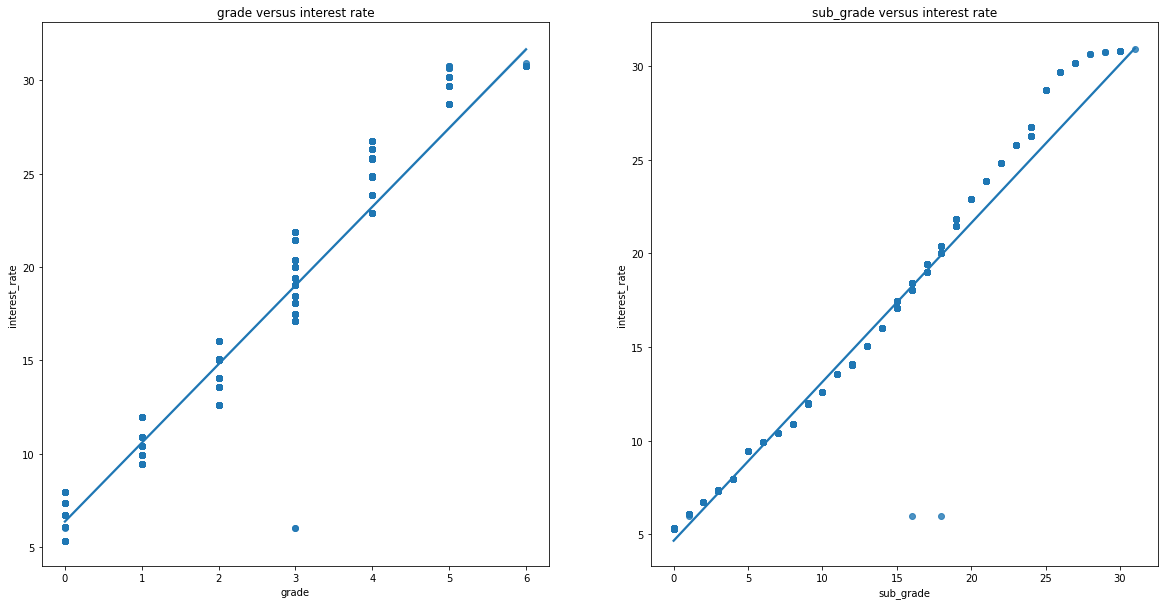

In [308]:
fig, axs = plt.subplots(ncols=2,figsize=(20, 10))
sns.regplot(loans_2['grade'],loans_2['interest_rate'], ax=axs[0]).set(title='grade versus interest rate')
sns.regplot(loans_2['sub_grade'],loans_2['interest_rate'], ax=axs[1]).set(title='sub_grade versus interest rate')

**Enhancements to Model** <br>
Cross validation can be done to get more reliable accuracy scores and results. Parameter tuning can also be done to improve model performance. More exploratory analysis could result in feature extraction or finding patterns in data that could improve model performance as well. <br>
**If I had more time** <br>
I only used default parameters and train_test_split method this time, so I could've done cross validation or parameter tuning to improve the model. If I had more time I would've be done more exploratory analysis and tried to learn about and extract more features that could potientally help improve the model and gain some insightful observations from the data.